In [1]:
import numpy as np
from utils import *
import csv
import keras.utils
from keras import backend as K
from keras.datasets import mnist
from keras.models import save_model,load_model,Model
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, UpSampling2D, AveragePooling2D, MaxPooling2D, Dense,Input, Dropout
from keras.layers import LeakyReLU,Reshape,BatchNormalization, Flatten
from keras.models import save_model
from tempfile import TemporaryFile
import tensorflow as tf
import pickle
import scipy.io as sio
import matplotlib.pyplot as plt
from IPython import display
import time
from sklearn.mixture import GaussianMixture
import umap
from copy import deepcopy
from PIL import Image
from sklearn.cluster import KMeans
from keras import regularizers
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

from keras.layers import Input, Conv2D, Activation, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import add
from keras.activations import relu, softmax
from keras.models import Model
from keras import regularizers

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.applications.resnet50 import ResNet50
import numpy as np
import matplotlib.pyplot as plt
import keras.layers as layers
from keras.models import Model
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from keras.optimizers import SGD
from array import array 

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
# ! pip install --user umap-learn
# ! pip uninstall --user keras
# ! pip install --user keras==2.1.6
# ! pip install --user matplotlib
# ! pip install --user np_utils
#! pip install --user  Pillow

In [7]:
epochs = 10000
epochstep = epochs/100
nofclasses=12
batchsize=64 
nofprojections = 100
wd = 224


## Data Generation

In [56]:
USPSMat  = []
USPSTar  = []
curPath  = r'/nas/home/mrostami/NeurIPS2020/imageCLEF_resnet50/'
savedImg = []
folder =  'c_c.csv'

with open(curPath +folder, newline='') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        USPSMat.append(row)


dataX_train = np.zeros([len(USPSMat),2048])
labelX_train = np.zeros([len(USPSMat)])

i = 0
with open(curPath +folder, newline='') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        temp = np.array([float(i) if '.' in i else int(i) for i in row])
        dataX_train[i,:] = temp[:2048]
        labelX_train[i] = int(temp[2048])
        i = i + 1
 
    
dataX_test = dataX_train
labelX_train = keras.utils.to_categorical(labelX_train, nofclasses)
labelX_test = labelX_train


(600, 12)

In [10]:
USPSMat  = []
USPSTar  = []
curPath  = r'/nas/home/mrostami/NeurIPS2020/imageCLEF_resnet50/'
savedImg = []
folder =  'c_i.csv'

with open(curPath +folder, newline='') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        USPSMat.append(row)


dataY_train = np.zeros([len(USPSMat),2048])
labelY_train = np.zeros([len(USPSMat)])

i = 0
with open(curPath +folder, newline='') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for row in readCSV:
        temp = np.array([float(i) if '.' in i else int(i) for i in row])
        dataY_train[i,:] = temp[:2048]
        labelY_train[i] = int(temp[2048])
        i = i + 1
 
    
dataY_test = dataY_train
labelY_train = keras.utils.to_categorical(labelY_train, nofclasses)
labelY_test = labelY_train


###  X is input and Z the embedding space

In [12]:
imgX = Input(shape=(2048,), name="input_img")  # adapt this if using `channels_first` image data format
labelX=K.placeholder(shape=(None,nofclasses),dtype='float32') #labels of input images oneHot

## Encoder, Decoder and Classifier NN

In [13]:
def encoderNN(imgX = imgX, nofclasses=nofclasses):

    
     
    
    x = Dense(1000, activation='relu', use_bias=True, kernel_initializer='glorot_uniform')(imgX)
    x = Dense(500, activation='relu', use_bias=True, kernel_initializer='glorot_uniform')(x)
    #x = Dense(100, activation='relu', use_bias=True, kernel_initializer='glorot_uniform')(x)
    x = Dense(nofclasses, activation='relu', use_bias=True, kernel_initializer='glorot_uniform')(x)
    
    encoderX = Model(input=imgX,output=x)
    return encoderX


In [14]:
encoderX = encoderNN(imgX = imgX, nofclasses=nofclasses)

/nas/home/mrostami/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # This is added back by InteractiveShellApp.init_path()


In [15]:
encoderX.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              2049000   
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_3 (Dense)              (None, 12)                6012      
Total params: 2,555,512
Trainable params: 2,555,512
Non-trainable params: 0
_________________________________________________________________


In [16]:
def    classifierNN(nofclasses):
    yin =  Input(shape=( nofclasses,) )

    
    probX = Dense(units=nofclasses, kernel_regularizer=regularizers.l2(0.01))(yin)
    probX = Activation(softmax)(probX)


    classifier=Model(inputs=[yin],outputs=[probX])
    return classifier
#    classifier.summary()
classifier = classifierNN(nofclasses)
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 12)                156       
_________________________________________________________________
activation_1 (Activation)    (None, 12)                0         
Total params: 156
Trainable params: 156
Non-trainable params: 0
_________________________________________________________________


# Training on Task 1

In [17]:

discriminationLoss=K.mean(K.categorical_crossentropy(labelX,classifier(encoderX(imgX)))) 

params=encoderX.weights  + classifier.weights  

myLoss = discriminationLoss

opt = SGD(lr=1e-3, momentum = .9) # very important 
updates = opt.get_updates(myLoss,params)
train = K.function(inputs=[imgX,labelX],outputs=[discriminationLoss],updates=updates)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [18]:
print(keras.__version__) #2.1.6

2.1.6


In [19]:
print(tf.__version__) #1.15.0

1.15.0


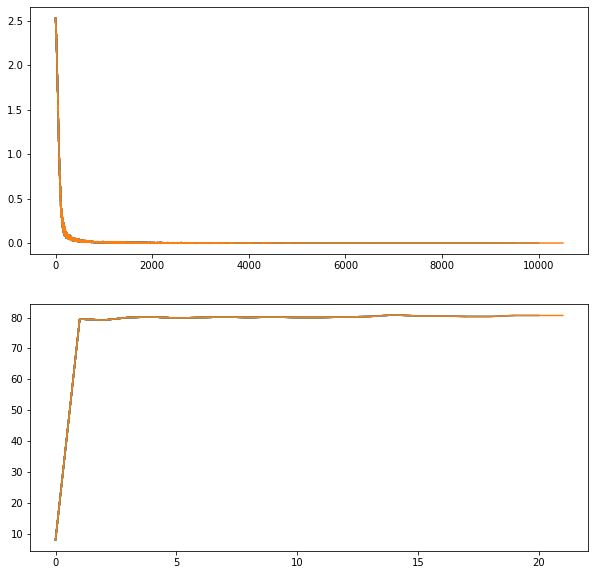

KeyboardInterrupt: 

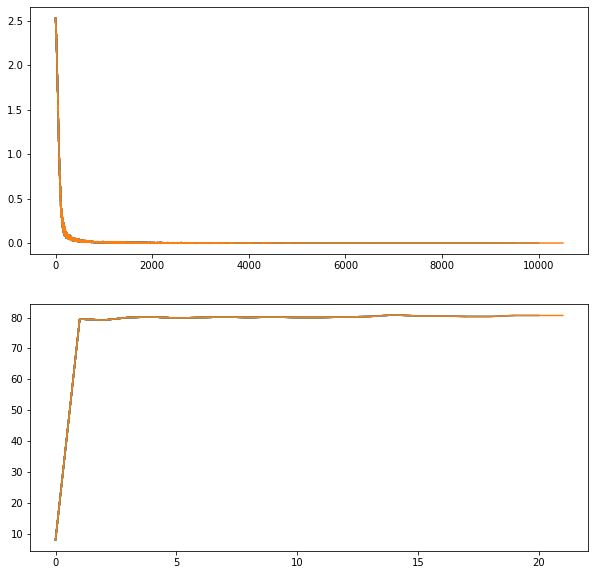

In [20]:
loss = []
testXperf = []
fig,ax=plt.subplots(2,figsize=(10,10))
# reinitLayers(encoderX)
# reinitLayers(encoderY)
# reinitLayers(classifier)

#seed=np.random.randint(0,high=100)

for itr in range(epochs):
    indTrainDataX,trainLabelX=batchGenerator(labelX_train,batchsize,nofclasses=nofclasses)
    trainDataX=dataX_train[indTrainDataX,...]
    


    loss.append(train(inputs=[trainDataX, trainLabelX ]))
     
    if itr%epochstep==0:
        
        perd_label_Y = classifier.predict(encoderX.predict(dataY_test))
        testXperf.append(100*float(sum(1*(np.argmax(perd_label_Y,axis=1)==np.argmax(np.squeeze(labelY_test),axis=1))))/perd_label_Y.shape[0])

        
        ax[0].plot(np.asarray(loss))
        ax[1].plot(np.asarray(testXperf))
        display.clear_output(wait=True)
        display.display(plt.gcf()) 
        time.sleep(1e-3) 
        
        
        
        


In [24]:
gmmX = encoderX.predict(dataX_train)
gmmY = np.argmax(labelX_train,axis=1)


In [25]:
yper = classifier.predict(encoderX.predict(dataX_train))
yper = np.argmax(yper, axis=1)

In [26]:
gmmX = gmmX[gmmY==yper,:]
gmmY = gmmY[gmmY==yper]

In [27]:
gmmModel =  GaussianMixture(n_components=nofclasses,covariance_type='full', max_iter=300,init_params='kmeans', tol=1e-04) 


In [28]:
gmmModel.fit(gmmX,gmmY)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=300,
                means_init=None, n_components=12, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.0001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [29]:
gmmModelSingle =  GaussianMixture(n_components=1,covariance_type='full') 

for i in range(nofclasses):
    a= gmmX[gmmY==i,:]
    gmmModelSingle.fit(a)
    gmmModel.weights_[i] = gmmY[gmmY==i].shape[0]/gmmY.shape[0]
    gmmModel.covariances_[i] = gmmModelSingle.covariances_[0]
    gmmModel.means_[i] = gmmModelSingle.means_[0]
    
    gmmModel.precisions_cholesky_[i] = gmmModelSingle.precisions_cholesky_[0]
    gmmModel.precisions_[i] = gmmModelSingle.precisions_[0]
    
    
    
    
    

# Target Task

In [41]:
imgY = Input(shape=(nofclasses,) )  # adapt this if using `channels_first` image data format
labelY=K.placeholder(shape=(None,nofclasses),dtype='float32') #labels of input images oneHot
lamda2=1e-3

theta=K.variable(generateTheta(nofprojections,nofclasses),) 


#discriminationLoss=  K.mean(K.categorical_crossentropy(labelY,classifier(imgY)))

discriminationLoss= K.mean(K.categorical_crossentropy(labelY,classifier(imgY)))
                    #+ K.mean(K.categorical_crossentropy(labelX,classifier(encoderX(imgX))))
                     



matchingLoss=sWasserstein(encoderX(imgX),imgY,theta,nclass=nofclasses,Cp=None,Cq=None,)


myLoss= discriminationLoss +lamda2*matchingLoss #+lamda*autorec


params=encoderX.weights  + classifier.weights #+ decoderX.weights

opt = Adam(lr=1e-4) # very important
updates = opt.get_updates(myLoss,params)
train = K.function(inputs=[imgX,imgY,labelY,theta],outputs=[lamda2*matchingLoss],updates=updates)

#train = K.function(inputs=[imgX,imgY,labelX,labelY,theta],outputs=[discriminationLoss,lamda2*matchingLoss],updates=updates)




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib64/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [42]:
batchsize = 200

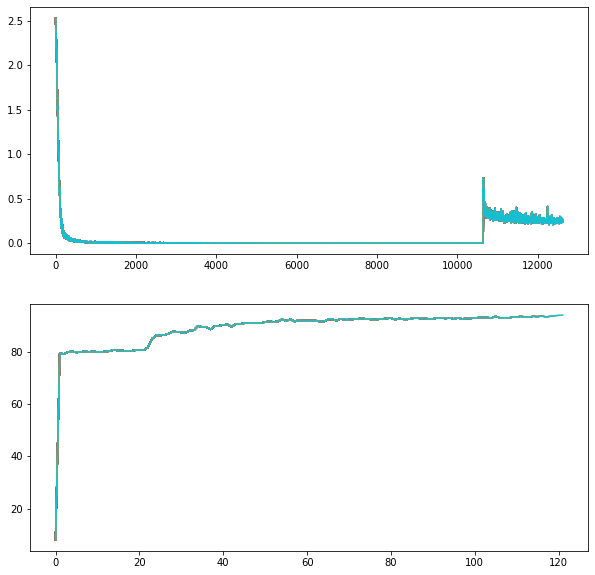

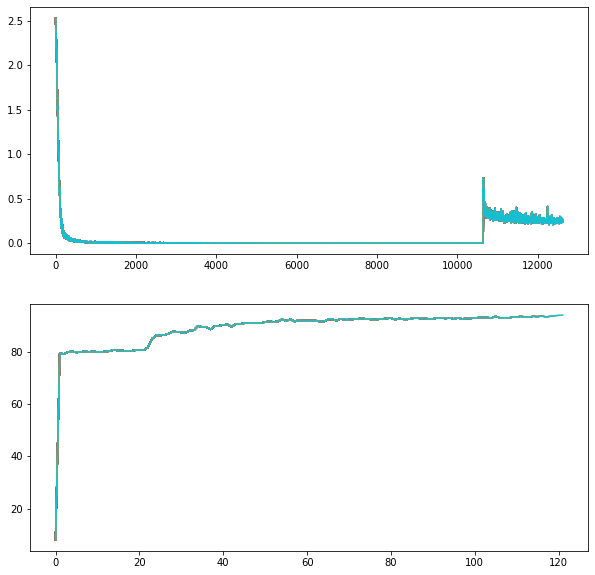

In [43]:
thres = .85
fig,ax=plt.subplots(2,figsize=(10,10))
# reinitLayers(encoderX)
# reinitLayers(encoderY)
# reinitLayers(classifier)

#seed=np.random.randint(0,high=100)
epochs2 = 20 * 100
epochstep = epochs2/100

for itr in range(epochs2):
    indTrainDataY,trainLabelY=batchGenerator(labelY_train,batchsize,nofclasses=nofclasses)
    trainDataY=dataY_train[indTrainDataY,...]
    
    perdLabbatchY = classifier.predict(encoderX.predict(trainDataY))
    problab = np.max(perdLabbatchY,axis=1)
    
    NNN =  1*(problab>thres).sum()
    
#     trainLabelY = np.zeros([NNN,nofclasses])
#     count = 0
#     trainDataYtemp = trainDataY
#     trainDataY = np.zeros([NNN,28,28,1])
#     for ijk in range(len(problab)):
#         if problab[ijk] > thres:
#             trainLabelY[count,:] = 1*(perdLabbatchY[ijk,:]>thres) 
#             trainDataY[count,:,:,:] = trainDataYtemp[ijk,:,:,:]
#             count = count + 1

       
    Yembed1 = np.zeros([5*batchsize,nofclasses])
    Yembed = np.zeros([5*batchsize,nofclasses])
    Yembedlabel = np.zeros([5*batchsize,nofclasses])
    
    Yembed,Yembedlabel1  = gmmModel.sample(n_samples=5*batchsize)
    
    Yembedlabel = keras.utils.to_categorical(Yembedlabel1)   
    
    
    theta_=generateTheta(nofprojections,nofclasses)
    loss.append(train(inputs=[trainDataY,Yembed,Yembedlabel,theta_]))
     
    if itr%epochstep==0:
        perd_label_Y = classifier.predict(encoderX.predict(dataY_test))
        testXperf.append(100*float(sum(1*(np.argmax(perd_label_Y,axis=1)==np.argmax(np.squeeze(labelY_test),axis=1))))/perd_label_Y.shape[0])
        
        ax[0].plot(np.asarray(loss))
        ax[1].plot(np.asarray(testXperf))
        display.clear_output(wait=True)
        display.display(plt.gcf()) 
        time.sleep(1e-3) 
        
        
        
        


In [47]:
perd_label_Y = classifier.predict(encoderX.predict(dataY_test))
print(100*float(sum(1*(np.argmax(perd_label_Y,axis=1)==np.argmax(np.squeeze(labelY_test),axis=1))))/perd_label_Y.shape[0])



94.0
